In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')

# generate continue variables, redo until p value is not too small

true correlation: 0.57


c:\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: covariance is not positive-semidefinite.
  # Remove the CWD from sys.path while we load stuff.


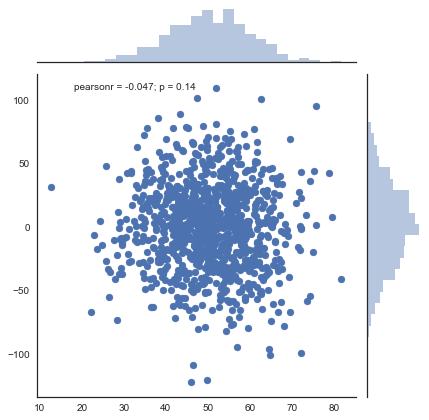

In [2]:
n = 1000
x_range = np.array([20, 80])
y_range = np.array([30, 40])
means = [x_range.mean(), y_range.mean()]
stds = [x_range.std() / 3, y_range.std()/3]
corr = 0.57463
print('true correlation: %.2f'%corr)
covs = [[stds[0]**2,   stds[1]*stds[0]*corr],
        [stds[0]*stds[1]**corr,   stds[1]**2]]
data = np.random.multivariate_normal(means, covs, n).T
data[0] = data[0] + np.random.randn(n)
data[1] = data[1] * np.random.randn(n)
sns.jointplot(data[0],data[1],)

# Parametric way - scipy correlation tests
pearson corrlation
<br />spearman rand-order correlation

In [3]:
from scipy import stats

In [4]:
# pearson
data = np.nan_to_num(data)
r, p = stats.pearsonr(data[0],data[1])
print('correlation: %.2f, p-value: %.2f'%(r,p))

correlation: -0.05, p-value: 0.14


In [5]:
# spearman
r, p = stats.spearmanr(data[0],data[1])
print('correlation: %2f, p-value: %.2f'%(r,p))

correlation: -0.053109, p-value: 0.09


In [6]:
r,p = stats.pearsonr(stats.rankdata(data[0]),stats.rankdata(data[1]))
print('correlation: %2f, p-value: %.2f'%(r,p))

correlation: -0.053109, p-value: 0.09


# 3 variables

In [30]:
np.random.seed(12345)
no_obs = 1000
means = np.random.randint(1,5,3)
no_cols = 3
sds = np.random.randint(1,5,3)
sd = np.diag(sds)

observations = np.random.normal(0,1,(no_cols,no_obs))
cor_matrix = np.array([[1.0,0.2,0.9],
                      [0.2,1.0,0.5],
                      [0.9,0.5,1.0]])
cov_matrix = np.dot(sd, np.dot(cor_matrix,sd))
Chol = np.linalg.cholesky(cov_matrix) # Cholesky decomposition

sam_eq_mean = Chol.dot(observations)
s = sam_eq_mean.T + means
samples = s.T
print(np.corrcoef(samples))

[[ 1.          0.1914363   0.90004894]
 [ 0.1914363   1.          0.49257247]
 [ 0.90004894  0.49257247  1.        ]]


In [31]:
data = pd.DataFrame(samples.T,columns=['a','b','c'])
data.head()

a         b         c
0  3.632320  2.299396  3.865325
1  0.241604  1.664202 -0.621932
2  3.901109  2.595274  2.248059
3  3.185347  1.133788  1.372302
4  5.496266  0.499099  3.252887

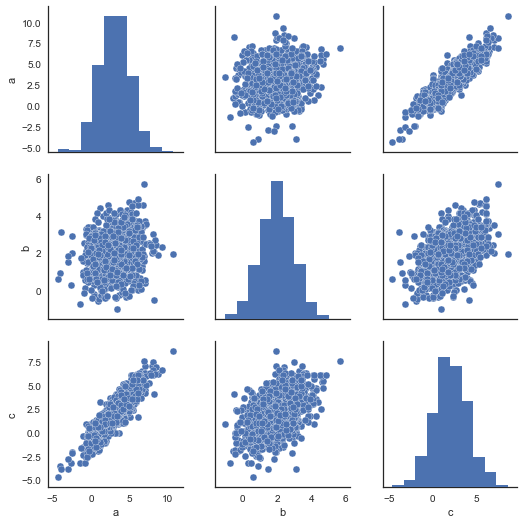

In [9]:
sns.pairplot(data)

In [32]:
# spearman
r, p = stats.spearmanr(data['a'],data['b'])
print('correlation: %2f, p-value: %.2f'%(r,p))

correlation: 0.185993, p-value: 0.00


In [11]:
import pymc3 as pm
import theano.tensor as T
# nbviewer.jupyter.org/github/sebp/bayesian-correlation/blob/master/bayesian_correlation_pymc3.ipynb

In [23]:
def precision(sigma, rho):
    C = T.alloc(rho, 2, 2)
    C = T.fill_diagonal(C, 1.)
    S = T.diag(sigma)
    return T.nlinalg.matrix_inverse(S.dot(C).dot(S))


def analyze(data):
    with pm.Model() as model:
        # priors might be adapted here to be less flat
        mu = pm.Normal('mu', mu=0., tau=0.000001, shape=2, testval=np.mean(data, axis=1))
        sigma = pm.Uniform('sigma', lower=1e-6, upper=1000., shape=2, testval=np.std(data, axis=1))
        rho = pm.Uniform('r', lower=-1., upper=1., testval=0)

        prec = pm.Deterministic('prec', precision(sigma, rho))
        mult_n = pm.MvNormal('mult_n', mu=mu, tau=prec, observed=data.T)

    return model

In [24]:
model = analyze(data[['a','b']].values.T)
with model:
    trace = pm.sample(50000,tune=25000,step=pm.Metropolis())

100%|███████████████████████████████████| 75000/75000 [01:29<00:00, 841.14it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002063E0F1E10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000002063E8395C0>]], dtype=object)

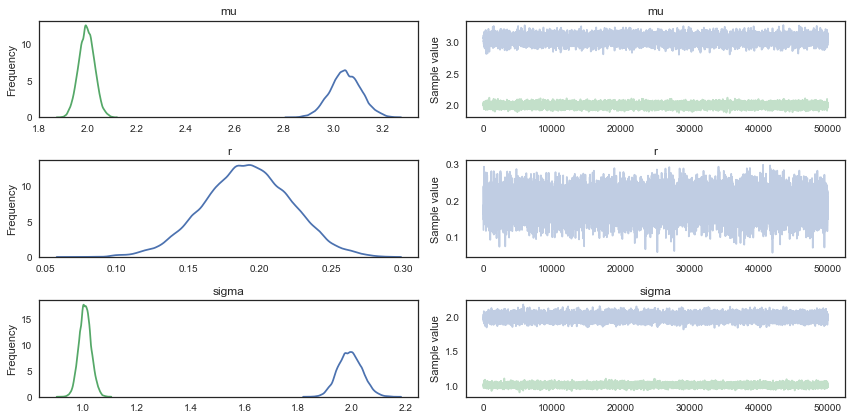

In [26]:
pm.traceplot(trace, varnames=['mu','r','sigma'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002063C57EF28>], dtype=object)

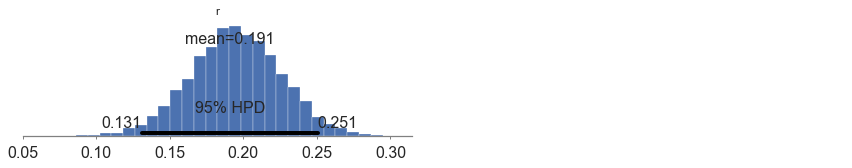

In [33]:
pm.plot_posterior(trace,varnames=['r'])